In [1]:
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, log_loss
import seaborn as sns
import os
import ast
import sys
import re
from statistics import mean, stdev
statistics_path = os.path.abspath("../")
sys.path.append(statistics_path)
import stats_utils
from matplotlib.ticker import MaxNLocator

In [2]:
path_to_exp_statistics = "/Users/admin/Desktop/thesis/dataset/metrics/"
path_to_exp_images = "/Users/admin/Desktop/thesis_writing/experiment_images/energy_experiments"

### We will compare the energy consumed on these circumstanes

1. 1 epoch × 100 rounds
2. 2 epochs × 50 rounds
3. 4 epochs × 25 rounds
4. 10 epochs × 10 rounds

In [3]:
exp_name = "exp_6_1_1"
df1 = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")

exp_name = "exp_6_2_1"
df2 = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")

exp_name = "exp_6_3_1"
df3 = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")

exp_name = "exp_6_4_1"
df4 = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")

dfs = [df1, df2, df3, df4]

In [14]:
def plot_acc_loss_from_dfs(
    dfs,
    get_accuracy_loss_values,
    path_to_exp_images,
    should_save=False,
    filename="accuracies_for_every_dataset",
    label_names=None,
    title=""
):
    accs = {}
    losses = {}

    # 1) Extract accuracy & loss per dataset
    for i, df in enumerate(dfs):
        label = label_names[i]
        first_client = ast.literal_eval(df["devices_names"][0])[0]
        acc, loss = get_accuracy_loss_values(df, first_client)
        accs[label] = acc
        losses[label] = loss

    # 2) Plot Accuracy with variable round lengths
    fig, ax = plt.subplots(figsize=(10, 6))
    for label, values in accs.items():
        rounds = list(range(1, len(values) + 1))
        ax.plot(rounds, values, label=label)

    ax.set_title(title)
    ax.set_xlabel("Federated Round")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()

    # 3) Show or save
    if not should_save:
        plt.show()
    else:
        path_to_file = os.path.join(path_to_exp_images, filename + ".png")
        fig.savefig(path_to_file, dpi=300)
        plt.close(fig)

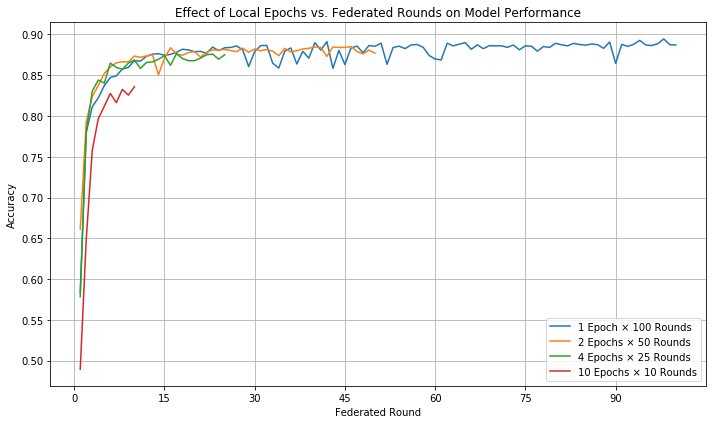

In [10]:
filename = "epoch_vs_federated_rounds"
title = "Effect of Local Epochs vs. Federated Rounds on Model Performance"

label_names = [
    "1 Epoch × 100 Rounds",
    "2 Epochs × 50 Rounds",
    "4 Epochs × 25 Rounds",
    "10 Epochs × 10 Rounds"
]

plot_acc_loss_from_dfs(dfs, stats_utils.get_accuracy_loss_values_for_dfs, path_to_exp_images, \
                     should_save=False, filename=filename, label_names=label_names, title=title)

In [4]:
def get_total_charge_drop(df):
    energy_df = stats_utils.extract_energy_data(df)
    charge_drops = energy_df
    charge_drops["charge_drop"] = charge_drops["charge_before"] - charge_drops["charge_after"]

    total_charge_drop_dict = {}
    # Plot each device's charge drop separately and add cumulative information to the legend
    for device in energy_df["device"].unique():
        subset = charge_drops[charge_drops["device"] == device]

        # Calculate cumulative charge consumption (first charge_before and last charge_after)
        first_charge_before = subset["charge_before"].iloc[0] / 1000
        last_charge_after = subset["charge_after"].iloc[-1] / 1000
        total_charge_drop = first_charge_before - last_charge_after
        
        total_charge_drop_dict[device] = total_charge_drop

    return total_charge_drop_dict

In [50]:
should_save = True
filename = "epoch_vs_federated_rounds"

final_accuracies = []
for df in dfs:
    first_client_name = ast.literal_eval(df['devices_names'][0])[0]
    acc, _ = stats_utils.get_accuracy_loss_values_for_dfs(df, first_client_name)
    final_accuracies.append(get_accuracy(df, first_client_name)[-1])

# Collect charge drop per device per experiment
device_names = set()
all_charge_drops = []

for df in dfs:
    drop_dict = get_total_charge_drop(df)
    device_names.update(drop_dict.keys())
    all_charge_drops.append(drop_dict)

device_names = sorted(device_names)
n_labels = len(label_names)
n_devices = len(device_names)

# Build matrix: rows = training settings, cols = devices
charge_matrix = np.full((n_labels, n_devices), np.nan)
for i, drop_dict in enumerate(all_charge_drops):
    for j, device in enumerate(device_names):
        value = drop_dict.get(device)
        if value is not None and not pd.isna(value):
            charge_matrix[i, j] = value

avg_drops = np.nanmean(charge_matrix, axis=1)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# 1. Per-device charge bar plot
width = 0.12
x = np.arange(n_labels)

for i, device in enumerate(device_names):
    offset = (i - n_devices / 2) * width + width / 2
    ax1.bar(x + offset, charge_matrix[:, i], width=width, label=device)

ax1.set_title("Per-Device Charge Drop per Training Configuration")
ax1.set_xticks(x)
ax1.set_xticklabels(label_names, rotation=20)
ax1.set_ylabel("Charge Drop (mAh)")
ax1.legend(title="Device", bbox_to_anchor=(1.01, 1), loc="upper left")
ax1.grid(True, axis='y')

# 2. Avg charge + accuracy
bar = ax2.bar(x, final_accuracies, width=0.4, label="Final Accuracy", color="skyblue")
ax2.set_ylabel("Final Accuracy")
ax2.set_ylim(0, 1)
ax2.set_xticks(x)
ax2.set_xticklabels(label_names, rotation=20)
ax2.grid(True, axis='y')

ax3 = ax2.twinx()
ax3.plot(x, avg_drops, color="red", marker="o", label="Avg. Charge Drop (mAh)")
ax3.set_ylabel("Avg. Charge Drop (mAh)")
ax3.set_ylim(0, np.nanmax(avg_drops) * 1.1)

# Shared legend
lines_labels = [ax2.get_legend_handles_labels(), ax3.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 0.99))

# fig.suptitle("Epoch vs Federated Round Trade-off: Device-Level and Average Energy Consumption")
plt.tight_layout(rect=[0, 0, 1, 0.96])

if not should_save:
    plt.show()
else:
    path_to_file = os.path.join(path_to_exp_images, filename + ".png")
    fig.savefig(path_to_file, dpi=300)
    plt.close(fig)

### 

In [4]:
energy_df = stats_utils.extract_energy_data(dfs[0])

In [5]:
energy_df.head()

,n_round,device,temperature_before,temperature_after,current_now_before,current_now_after,current_avg_before,current_avg_after,capacity_before,capacity_after,voltage_before,voltage_after,charge_before,charge_after
0,1,samsung SM-J730F,26.7,26.7,-2.540000e+02,-2.540000e+02,-1.350000e+02,-1.350000e+02,35,35,3771.0,3771.0,1288800.0,1288800.0
1,1,samsung SM-G975F,27.1,27.1,-3.570000e+02,-4.830000e+02,-1.600000e+02,-1.810000e+02,95,95,4091.0,4091.0,3764058.0,3764058.0
2,1,samsung SM-A510F,27.4,27.4,-9.700000e+01,-9.700000e+01,-1.560000e+02,-1.560000e+02,70,70,3937.0,3937.0,NaN,NaN
3,1,Xiaomi M2006C3MNG,26.8,26.8,-2.147484e+09,-2.147484e+09,-9.600000e+04,-9.600000e+04,91,91,4233.0,4233.0,4614610.0,4614610.0
4,1,realme RMX3370,27.2,27.2,6.700000e+01,1.170000e+02,-2.147484e+09,-2.147484e+09,36,36,3810.0,3810.0,1360000.0,1360000.0


In [9]:
label_names = [
    "1 Epoch × 100 Rounds",
    "2 Epochs × 50 Rounds",
    "4 Epochs × 25 Rounds",
    "10 Epochs × 10 Rounds"
]

should_save = True
filename = "epoch_vs_federated_rounds"

final_accuracies = []
for df in dfs:
#     first_client_name = ast.literal_eval(df['devices_names'][0])[0]
#     acc, _ = stats_utils.get_accuracy_loss_values_for_dfs(df, first_client_name)
#     final_accuracies.append(get_accuracy(df, first_client_name)[-1])
    first_client_name = ast.literal_eval(df['devices_names'][0])[0]
    acc, _ = stats_utils.get_accuracy_loss_values_for_dfs(df, first_client_name)
    final_accuracies.append(acc[-1])

# Collect charge drop per device per experiment
device_names = set()
all_charge_drops = []

for df in dfs:
    drop_dict = get_total_charge_drop(df)
    device_names.update(drop_dict.keys())
    all_charge_drops.append(drop_dict)

device_names.remove('samsung SM-A510F')
device_names.remove('Xiaomi M2006C3MNG')

device_names = sorted(device_names)
n_labels = len(label_names)
n_devices = len(device_names)

# Build matrix: rows = training settings, cols = devices
charge_matrix = np.full((n_labels, n_devices), np.nan)
for i, drop_dict in enumerate(all_charge_drops):
    for j, device in enumerate(device_names):
        value = drop_dict.get(device)
        if value is not None and not pd.isna(value):
            charge_matrix[i, j] = value

avg_drops = np.nanmean(charge_matrix, axis=1)
V = 3.7

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# 1. Per-device charge bar plot
width = 0.12
x = np.arange(n_labels)

for i, device in enumerate(device_names):
    offset = (i - n_devices / 2) * width + width / 2
    ax1.bar(x + offset, charge_matrix[:, i] * V, width=width, label=device)

ax1.set_title("Energy Consumed per Device Across Training Configurations")
ax1.set_xticks(x)
ax1.set_xticklabels(label_names, rotation=20)
ax1.set_ylabel("Energy Consumed (mWh)")
ax1.legend(title="Device", bbox_to_anchor=(1.01, 1), loc="upper left")
ax1.grid(True, axis='y')

# 2. Avg charge + accuracy
bar = ax2.bar(x, final_accuracies, width=0.4, label="Final Accuracy", color="skyblue")
ax2.set_ylabel("Final Accuracy")
ax2.set_ylim(0, 1)
ax2.set_xticks(x)
ax2.set_xticklabels(label_names, rotation=20)
ax2.grid(True, axis='y')

ax3 = ax2.twinx()
total_energy_consumed = np.sum(charge_matrix, axis=1) * V + (2 * V * avg_drops)
ax3.plot(x, total_energy_consumed, color="red", marker="o", label="Total Energy Consumption (mWh)")
ax3.set_ylabel("Total Energy Consumption (mWh)")
ax3.set_ylim(0, np.nanmax(total_energy_consumed) * 1.1)

# Shared legend
lines_labels = [ax2.get_legend_handles_labels(), ax3.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 0.99))

# fig.suptitle("Epoch vs Federated Round Trade-off: Device-Level and Average Energy Consumption")
plt.tight_layout(rect=[0, 0, 1, 0.96])

if not should_save:
    plt.show()
else:
    path_to_file = os.path.join(path_to_exp_images, filename + ".png")
    fig.savefig(path_to_file, dpi=300)
    plt.close(fig)

In [8]:
total_energy_consumed

array([2023.98633333, 1166.48666667,  655.751     ,  319.37166667])